# Adhering to constraints

This notebook explains our approach to `smallness regularization`, with the goal of adhering to prior knowledge of topography we're aiming to recover. In the scenario of a sediment-basement contact inversion, if we know the basement depth at a few points from drill holes or seismic data, we want the inverted results to adhere to these points, which we refer to as `constraints`. 

Again, we will use the same synthetic data from the past two user guides. 

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging

import pandas as pd
import verde as vd
import xarray as xr
from polartoolkit import utils as polar_utils

from invert4geom import inversion, plotting, synthetic, utils

## Create observed gravity data
To run the inversion, we need to have observed gravity data. In this simple example, we will first create a synthetic topography, which represents the `true` Earth topography which we hope to recover during the inverison. From this topography, we will create a layer of vertical right-rectangular prisms, which allows us to calculated the gravity effect of the topography. This will act as our observed gravity data. 

### True topography

In [2]:
# set grid parameters
spacing = 1000
region = [0, 40000, 0, 30000]

# create synthetic topography data
true_topography = synthetic.synthetic_topography_simple(
    spacing,
    region,
)

### Starting topography

Sample the starting topography at 10 random locations and regrid with those sampled values. This sumulates only knowing the depth to this topography at 10 boreholes.

In [3]:
# create 10 random point withing the region
num_constraints = 10
coords = vd.scatter_points(region=region, size=num_constraints, random_state=7)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points, true_topography, "upward", coord_names=("easting", "northing")
)

# grid the sampled values using verde
grd = vd.Spline()
coords = (constraint_points.easting, constraint_points.northing)
grd.fit(coords, constraint_points.upward)
starting_topography = grd.grid(
    region=region,
    spacing=spacing,
).scalars

# re-sample the starting topography at the constraint points to see how the gridded did
constraint_points = utils.sample_grids(
    constraint_points,
    starting_topography,
    "starting_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.starting_topography)
print(f"RMSE at the constraints between the starting and true topography: {rmse:.2f} m")

RMSE at the constraints between the starting and true topography: 0.14 m


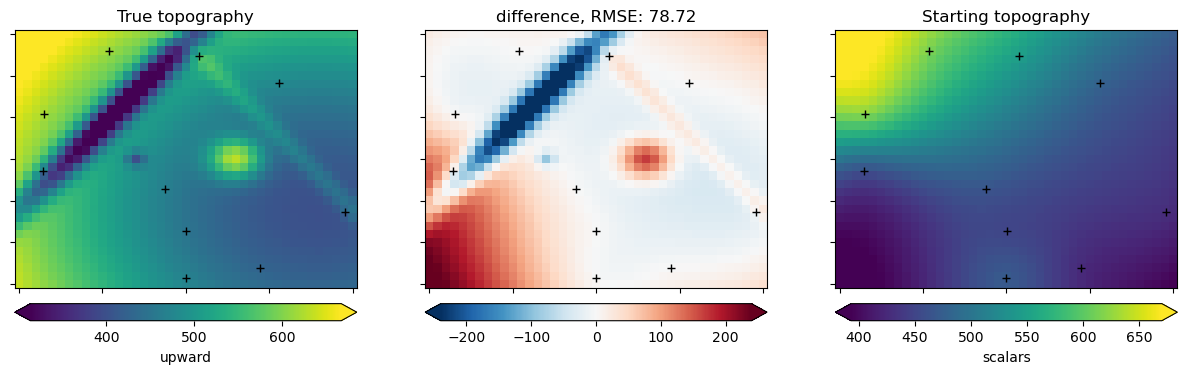

In [4]:
_ = polar_utils.grd_compare(
    true_topography,
    starting_topography,
    plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    # reverse_cpt=True,
    # cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
)

### Prism layer

In [5]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
density_contrast = 2670 - 1

# prisms are created between the mean topography value and the height of the topography
zref = true_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(true_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
prisms = utils.grids_to_prisms(
    true_topography,
    zref,
    density=density,
)

### Forward gravity of prism layer

In [6]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

grav_df["grav"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df

  0%|                                                                                                         …

,northing,easting,upward,grav
0,0.0,0.0,1000.0,9.534643
1,0.0,1000.0,1000.0,10.422834
2,0.0,2000.0,1000.0,9.949973
3,0.0,3000.0,1000.0,9.269279
4,0.0,4000.0,1000.0,8.532160
...,...,...,...,...
1266,30000.0,36000.0,1000.0,3.332716
1267,30000.0,37000.0,1000.0,3.330307
1268,30000.0,38000.0,1000.0,3.335438
1269,30000.0,39000.0,1000.0,3.300721


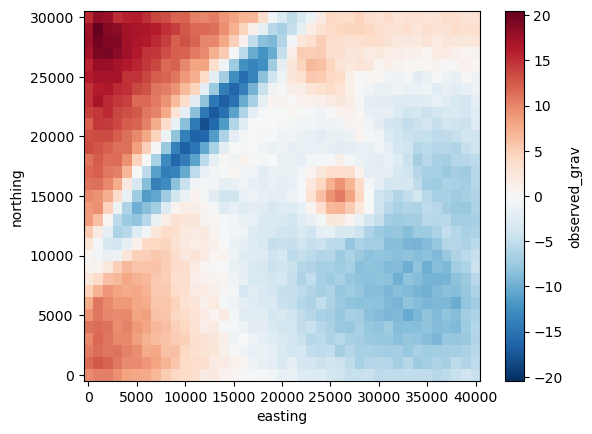

In [7]:
# contaminate gravity with 1 mGal of random noise
grav_df["observed_grav"], stddev = synthetic.contaminate(
    grav_df.grav,
    stddev=0.5,
    percent=False,
    seed=0,
)

grav_df.set_index(["northing", "easting"]).to_xarray().observed_grav.plot()

## Gravity misfit
Now we need to calculate the forward gravity of the starting topography. We then can subtract it from our observed gravity to get a starting gravity misfit.

In [8]:
# for a reference level we use the mean value of the starting model
zref = starting_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(starting_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density,
)

# calculate forward gravity of starting prism layer
grav_df["starting_grav"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

# calculate misfit as observed - starting
grav_df["misfit"] = grav_df["observed_grav"] - grav_df["starting_grav"]

# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and the
# full misfit is equal to the residual misfit.

# set regional misfit to 0
grav_df["reg"] = 0

# set the residual misfit to the full misfit
grav_df["res"] = grav_df.misfit

grav_df

  0%|                                                                                                         …

,northing,easting,upward,grav,observed_grav,starting_grav,misfit,reg,res
0,0.0,0.0,1000.0,9.534643,9.617711,-6.537446,16.155156,0,16.155156
1,0.0,1000.0,1000.0,10.422834,10.376985,-7.742933,18.119918,0,18.119918
2,0.0,2000.0,1000.0,9.949973,10.290387,-7.851638,18.142025,0,18.142025
3,0.0,3000.0,1000.0,9.269279,9.341932,-7.723797,17.065729,0,17.065729
4,0.0,4000.0,1000.0,8.532160,8.284528,-7.492407,15.776935,0,15.776935
...,...,...,...,...,...,...,...,...,...
1266,30000.0,36000.0,1000.0,3.332716,2.794223,-0.019163,2.813386,0,2.813386
1267,30000.0,37000.0,1000.0,3.330307,3.683446,-0.297847,3.981293,0,3.981293
1268,30000.0,38000.0,1000.0,3.335438,3.501867,-0.557034,4.058900,0,4.058900
1269,30000.0,39000.0,1000.0,3.300721,2.848068,-0.776698,3.624766,0,3.624766


## Weighting grid
To force the invesion to adhere to the starting model we need to supply a weighting grid. At each iteration, the `correction grid` is multiplied by this weighting grid to alter the iteration's correction. Therefore, this weighting grid should be ~0 at the constraints, so that they aren't altered from the starting model. These values should increase to ~1 at a distance to allow the inversion to be un-affected at locations far from constraints. 

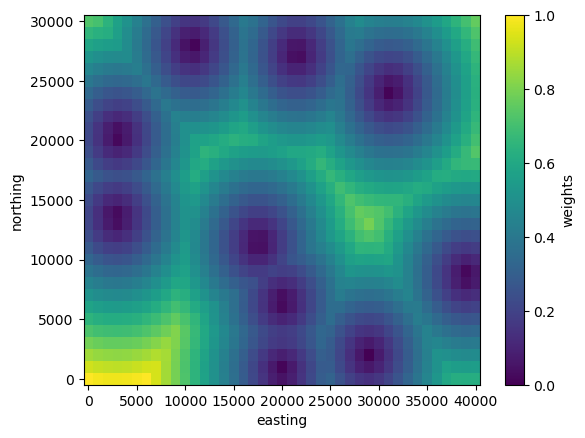

In [9]:
# calculate the distance between each grid cell and the nearest constraint, then
# normalize those values between 0 and 1
min_dist = utils.normalized_mindist(
    constraint_points,
    starting_prisms,
    low=0,
    high=1,
)
starting_prisms["weights"] = min_dist
starting_prisms.weights.plot()

## Perform inversion
Now we can perform the inversion, supplied the argument `weights_after_solving=True` and ensuring that the weighting grid is included as the `weights` variable to the argument `prism_layer`. Note that we have increased the `max_iterations` from 10 to 20. This is because the weighting grid reduces the correction values at each iterations, resulting in the need for more iterations.

INFO:root:starting inversion


INFO:root:extracted prism spacing is 1000.0


INFO:root:
 #################################### 
 iteration 1


INFO:root:Layer correction median: -4.2326 m, RMSE:33.2999 m


INFO:root:updated misfit RMSE: 5.4762


INFO:root:updated L2-norm: 2.3401, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.138, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 2


INFO:root:Layer correction median: -2.2882 m, RMSE:25.5724 m


INFO:root:updated misfit RMSE: 4.3377


INFO:root:updated L2-norm: 2.0827, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.1236, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 3


INFO:root:Layer correction median: 1.1204 m, RMSE:20.0847 m


INFO:root:updated misfit RMSE: 3.5263


INFO:root:updated L2-norm: 1.8779, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.1091, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 4


INFO:root:Layer correction median: 2.4994 m, RMSE:16.1557 m


INFO:root:updated misfit RMSE: 2.9356


INFO:root:updated L2-norm: 1.7133, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.096, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 5


INFO:root:Layer correction median: 3.009 m, RMSE:13.2905 m


INFO:root:updated misfit RMSE: 2.4945


INFO:root:updated L2-norm: 1.5794, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0848, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 6


INFO:root:Layer correction median: 2.8829 m, RMSE:11.1491 m


INFO:root:updated misfit RMSE: 2.1572


INFO:root:updated L2-norm: 1.4687, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0754, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 7


INFO:root:Layer correction median: 2.4034 m, RMSE:9.5105 m


INFO:root:updated misfit RMSE: 1.8935


INFO:root:updated L2-norm: 1.376, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0674, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 8


INFO:root:Layer correction median: 1.9428 m, RMSE:8.2297 m


INFO:root:updated misfit RMSE: 1.6833


INFO:root:updated L2-norm: 1.2974, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0606, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 9


INFO:root:Layer correction median: 1.5712 m, RMSE:7.2099 m


INFO:root:updated misfit RMSE: 1.513


INFO:root:updated L2-norm: 1.23, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0548, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 10


INFO:root:Layer correction median: 1.2695 m, RMSE:6.3844 m


INFO:root:updated misfit RMSE: 1.3729


INFO:root:updated L2-norm: 1.1717, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0498, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 11


INFO:root:Layer correction median: 1.0341 m, RMSE:5.7067 m


INFO:root:updated misfit RMSE: 1.2561


INFO:root:updated L2-norm: 1.1208, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0455, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 12


INFO:root:Layer correction median: 0.8543 m, RMSE:5.1429 m


INFO:root:updated misfit RMSE: 1.1576


INFO:root:updated L2-norm: 1.0759, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0417, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 13


INFO:root:Layer correction median: 0.7103 m, RMSE:4.6684 m


INFO:root:updated misfit RMSE: 1.0735


INFO:root:updated L2-norm: 1.0361, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0384, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 14


INFO:root:Layer correction median: 0.5994 m, RMSE:4.2647 m


INFO:root:updated misfit RMSE: 1.001


INFO:root:updated L2-norm: 1.0005, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0356, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 15


INFO:root:Layer correction median: 0.5117 m, RMSE:3.9176 m


INFO:root:updated misfit RMSE: 0.9379


INFO:root:updated L2-norm: 0.9685, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0331, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 16


INFO:root:Layer correction median: 0.4503 m, RMSE:3.6166 m


INFO:root:updated misfit RMSE: 0.8826


INFO:root:updated L2-norm: 0.9395, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0309, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 17


INFO:root:Layer correction median: 0.3864 m, RMSE:3.3531 m


INFO:root:updated misfit RMSE: 0.8337


INFO:root:updated L2-norm: 0.9131, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0289, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 18


INFO:root:Layer correction median: 0.3334 m, RMSE:3.1208 m


INFO:root:updated misfit RMSE: 0.7902


INFO:root:updated L2-norm: 0.8889, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0272, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 19


INFO:root:Layer correction median: 0.2978 m, RMSE:2.9145 m


INFO:root:updated misfit RMSE: 0.7513


INFO:root:updated L2-norm: 0.8668, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0256, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 20


INFO:root:Layer correction median: 0.2716 m, RMSE:2.7301 m


INFO:root:updated misfit RMSE: 0.7162


INFO:root:updated L2-norm: 0.8463, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0242, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 21


INFO:root:Layer correction median: 0.2518 m, RMSE:2.5643 m


INFO:root:updated misfit RMSE: 0.6845


INFO:root:updated L2-norm: 0.8273, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0229, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 22


INFO:root:Layer correction median: 0.2429 m, RMSE:2.4145 m


INFO:root:updated misfit RMSE: 0.6556


INFO:root:updated L2-norm: 0.8097, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0218, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 23


INFO:root:Layer correction median: 0.2195 m, RMSE:2.2784 m


INFO:root:updated misfit RMSE: 0.6293


INFO:root:updated L2-norm: 0.7933, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0207, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 24


INFO:root:Layer correction median: 0.2039 m, RMSE:2.1542 m


INFO:root:updated misfit RMSE: 0.6052


INFO:root:updated L2-norm: 0.778, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0197, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 25


INFO:root:Layer correction median: 0.1793 m, RMSE:2.0406 m


INFO:root:updated misfit RMSE: 0.5831


INFO:root:updated L2-norm: 0.7636, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0188, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 26


INFO:root:Layer correction median: 0.1641 m, RMSE:1.9362 m


INFO:root:updated misfit RMSE: 0.5627


INFO:root:updated L2-norm: 0.7501, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.018, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 27


INFO:root:Layer correction median: 0.1533 m, RMSE:1.8399 m


INFO:root:updated misfit RMSE: 0.5439


INFO:root:updated L2-norm: 0.7375, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0172, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 28


INFO:root:Layer correction median: 0.141 m, RMSE:1.751 m


INFO:root:updated misfit RMSE: 0.5264


INFO:root:updated L2-norm: 0.7255, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0164, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 29


INFO:root:Layer correction median: 0.1356 m, RMSE:1.6686 m


INFO:root:updated misfit RMSE: 0.5102


INFO:root:updated L2-norm: 0.7143, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0157, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 30


INFO:root:Layer correction median: 0.1287 m, RMSE:1.5922 m


INFO:root:updated misfit RMSE: 0.4952


INFO:root:updated L2-norm: 0.7037, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0151, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 31


INFO:root:Layer correction median: 0.125 m, RMSE:1.521 m


INFO:root:updated misfit RMSE: 0.4812


INFO:root:updated L2-norm: 0.6937, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0145, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 32


INFO:root:Layer correction median: 0.1141 m, RMSE:1.4547 m


INFO:root:updated misfit RMSE: 0.4681


INFO:root:updated L2-norm: 0.6842, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0139, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 33


INFO:root:Layer correction median: 0.1054 m, RMSE:1.3927 m


INFO:root:updated misfit RMSE: 0.4558


INFO:root:updated L2-norm: 0.6752, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0133, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 34


INFO:root:Layer correction median: 0.0933 m, RMSE:1.3348 m


INFO:root:updated misfit RMSE: 0.4444


INFO:root:updated L2-norm: 0.6666, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0128, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 35


INFO:root:Layer correction median: 0.0818 m, RMSE:1.2805 m


INFO:root:updated misfit RMSE: 0.4336


INFO:root:updated L2-norm: 0.6585, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0123, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 36


INFO:root:Layer correction median: 0.0742 m, RMSE:1.2296 m


INFO:root:updated misfit RMSE: 0.4236


INFO:root:updated L2-norm: 0.6508, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0118, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 37


INFO:root:Layer correction median: 0.0694 m, RMSE:1.1818 m


INFO:root:updated misfit RMSE: 0.4141


INFO:root:updated L2-norm: 0.6435, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0114, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 38


INFO:root:Layer correction median: 0.0663 m, RMSE:1.1369 m


INFO:root:updated misfit RMSE: 0.4051


INFO:root:updated L2-norm: 0.6365, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.011, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 39


INFO:root:Layer correction median: 0.0635 m, RMSE:1.0946 m


INFO:root:updated misfit RMSE: 0.3967


INFO:root:updated L2-norm: 0.6298, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0106, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 40


INFO:root:Layer correction median: 0.0624 m, RMSE:1.0548 m


INFO:root:updated misfit RMSE: 0.3888


INFO:root:updated L2-norm: 0.6235, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0102, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 41


INFO:root:Layer correction median: 0.0549 m, RMSE:1.0172 m


INFO:root:updated misfit RMSE: 0.3812


INFO:root:updated L2-norm: 0.6174, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0098, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 42


INFO:root:Layer correction median: 0.0508 m, RMSE:0.9817 m


INFO:root:updated misfit RMSE: 0.3741


INFO:root:updated L2-norm: 0.6116, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0095, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 43


INFO:root:Layer correction median: 0.0498 m, RMSE:0.9482 m


INFO:root:updated misfit RMSE: 0.3674


INFO:root:updated L2-norm: 0.6061, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0091, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 44


INFO:root:Layer correction median: 0.0462 m, RMSE:0.9165 m


INFO:root:updated misfit RMSE: 0.361


INFO:root:updated L2-norm: 0.6008, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0088, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 45


INFO:root:Layer correction median: 0.045 m, RMSE:0.8866 m


INFO:root:updated misfit RMSE: 0.3549


INFO:root:updated L2-norm: 0.5957, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0085, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 46


INFO:root:Layer correction median: 0.0443 m, RMSE:0.8582 m


INFO:root:updated misfit RMSE: 0.3491


INFO:root:updated L2-norm: 0.5909, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0082, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 47


INFO:root:Layer correction median: 0.0444 m, RMSE:0.8312 m


INFO:root:updated misfit RMSE: 0.3436


INFO:root:updated L2-norm: 0.5862, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.008, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 48


INFO:root:Layer correction median: 0.041 m, RMSE:0.8057 m


INFO:root:updated misfit RMSE: 0.3384


INFO:root:updated L2-norm: 0.5817, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0077, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 49


INFO:root:Layer correction median: 0.0395 m, RMSE:0.7815 m


INFO:root:updated misfit RMSE: 0.3334


INFO:root:updated L2-norm: 0.5774, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0075, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 50


INFO:root:Layer correction median: 0.0383 m, RMSE:0.7584 m


INFO:root:updated misfit RMSE: 0.3286


INFO:root:updated L2-norm: 0.5732, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0072, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 51


INFO:root:Layer correction median: 0.0397 m, RMSE:0.7366 m


INFO:root:updated misfit RMSE: 0.324


INFO:root:updated L2-norm: 0.5692, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.007, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 52


INFO:root:Layer correction median: 0.0396 m, RMSE:0.7158 m


INFO:root:updated misfit RMSE: 0.3196


INFO:root:updated L2-norm: 0.5654, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0068, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 53


INFO:root:Layer correction median: 0.0374 m, RMSE:0.696 m


INFO:root:updated misfit RMSE: 0.3154


INFO:root:updated L2-norm: 0.5616, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0066, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 54


INFO:root:Layer correction median: 0.035 m, RMSE:0.6771 m


INFO:root:updated misfit RMSE: 0.3114


INFO:root:updated L2-norm: 0.5581, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0064, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 55


INFO:root:Layer correction median: 0.034 m, RMSE:0.6591 m


INFO:root:updated misfit RMSE: 0.3076


INFO:root:updated L2-norm: 0.5546, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0062, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 56


INFO:root:Layer correction median: 0.0336 m, RMSE:0.642 m


INFO:root:updated misfit RMSE: 0.3039


INFO:root:updated L2-norm: 0.5512, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0061, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 57


INFO:root:Layer correction median: 0.0319 m, RMSE:0.6256 m


INFO:root:updated misfit RMSE: 0.3003


INFO:root:updated L2-norm: 0.548, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0059, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 58


INFO:root:Layer correction median: 0.0316 m, RMSE:0.61 m


INFO:root:updated misfit RMSE: 0.2969


INFO:root:updated L2-norm: 0.5449, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0058, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 59


INFO:root:Layer correction median: 0.0296 m, RMSE:0.5951 m


INFO:root:updated misfit RMSE: 0.2936


INFO:root:updated L2-norm: 0.5418, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0056, tolerance: 1.005


INFO:root:
 #################################### 
 iteration 60


INFO:root:Layer correction median: 0.0299 m, RMSE:0.5809 m


INFO:root:updated misfit RMSE: 0.2904


INFO:root:updated L2-norm: 0.5389, tolerance: 0.5


INFO:root:updated delta L2-norm : 1.0055, tolerance: 1.005


INFO:root:
Inversion terminated after 60 iterations with L2-norm=0.54 because maximum number of iterations (60) reached.


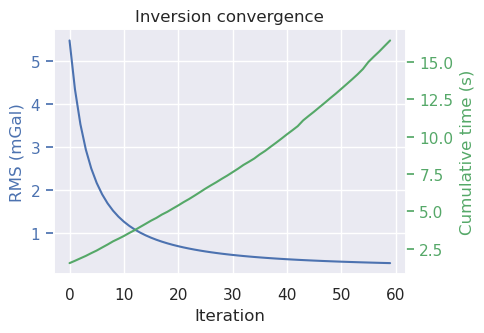

In [10]:
# set Python's logging level to get information about the inversion\s progress
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# run the inversion
results = inversion.run_inversion(
    input_grav=grav_df,
    input_grav_column="observed_grav",
    prism_layer=starting_prisms,
    zref=zref,
    density_contrast=density_contrast,
    # display the convergence of the inversion
    plot_convergence=True,
    # choose the small prism approximation method for calculating the vertical
    # derivative of gravity
    deriv_type="annulus",
    solver_damping=0.1,
    # set stopping criteria
    max_iterations=60,
    l2_norm_tolerance=0.5,
    delta_l2_norm_tolerance=1.005,
    # enable the use of weights
    weights_after_solving=True,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

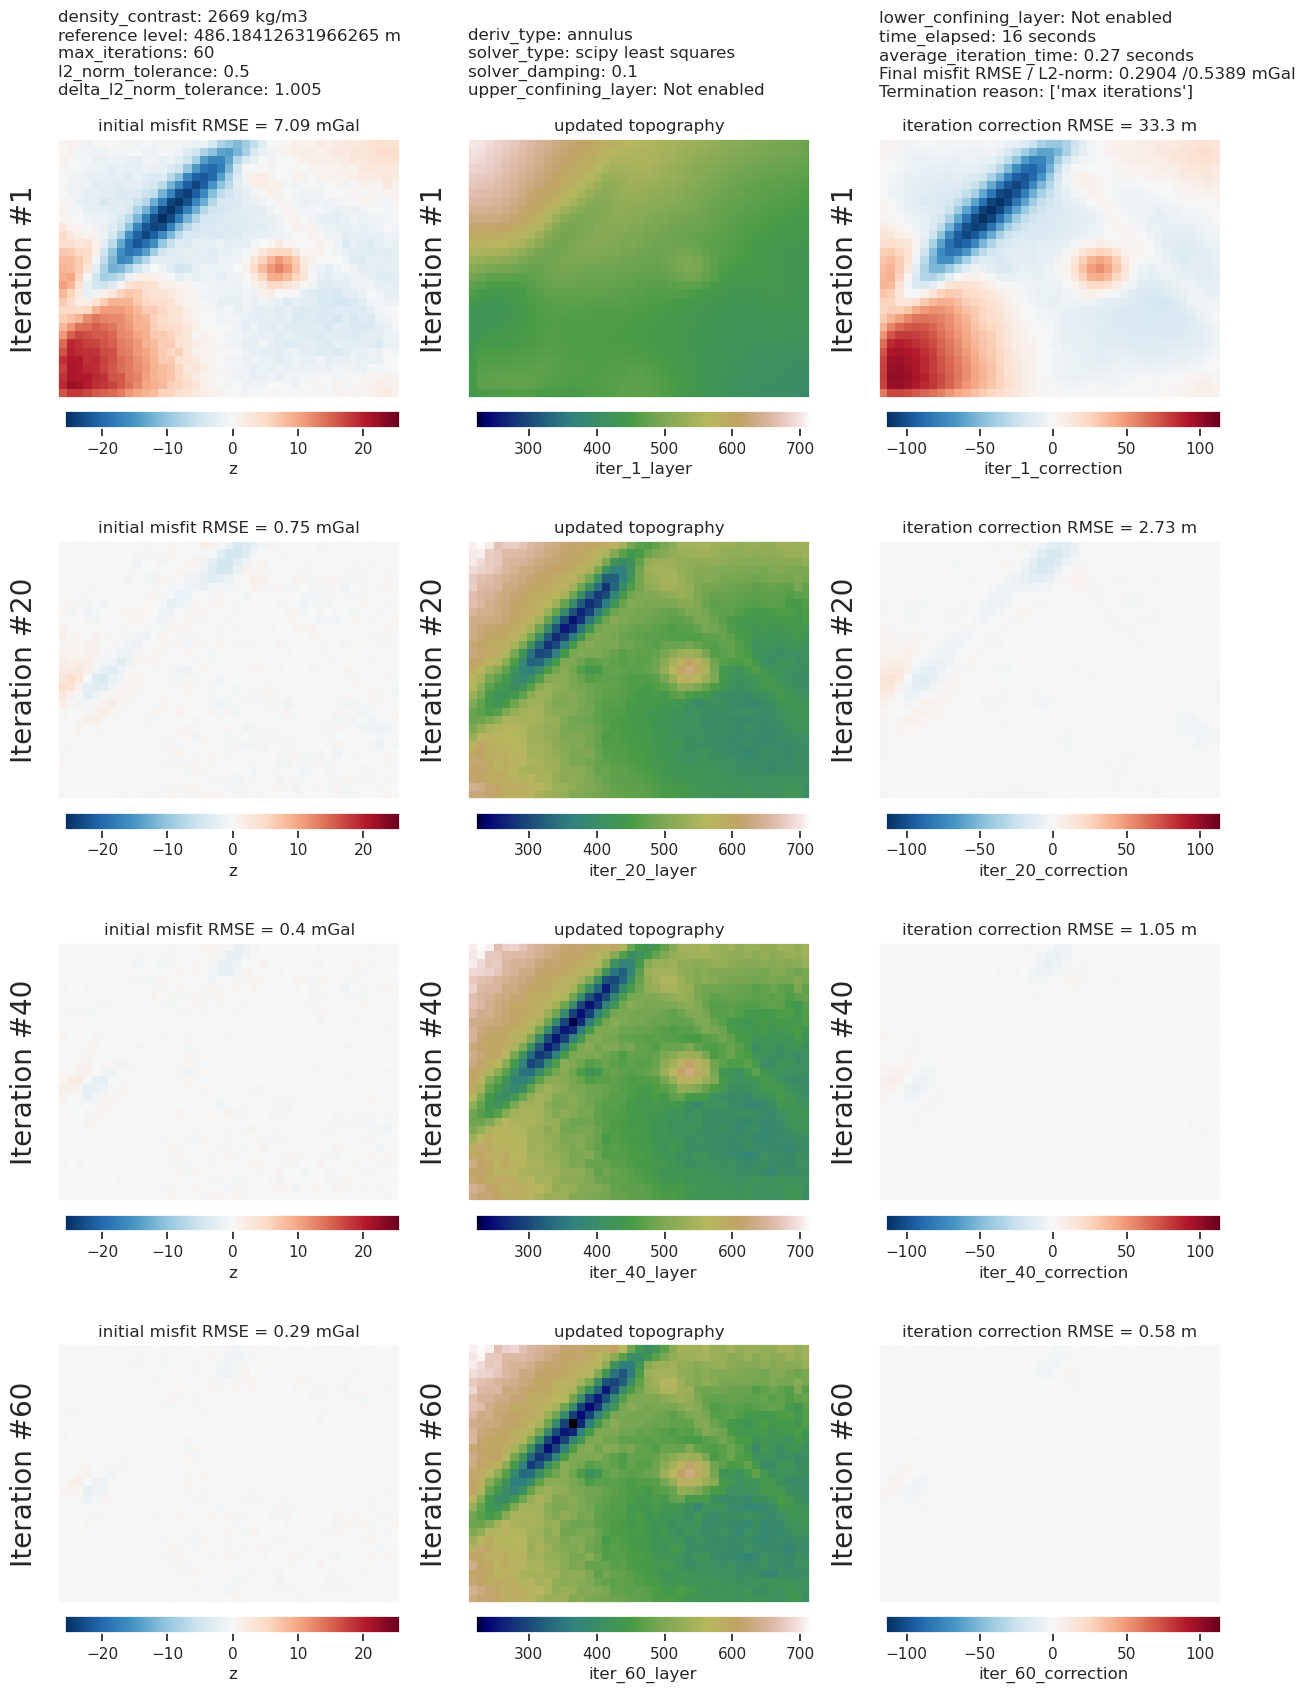

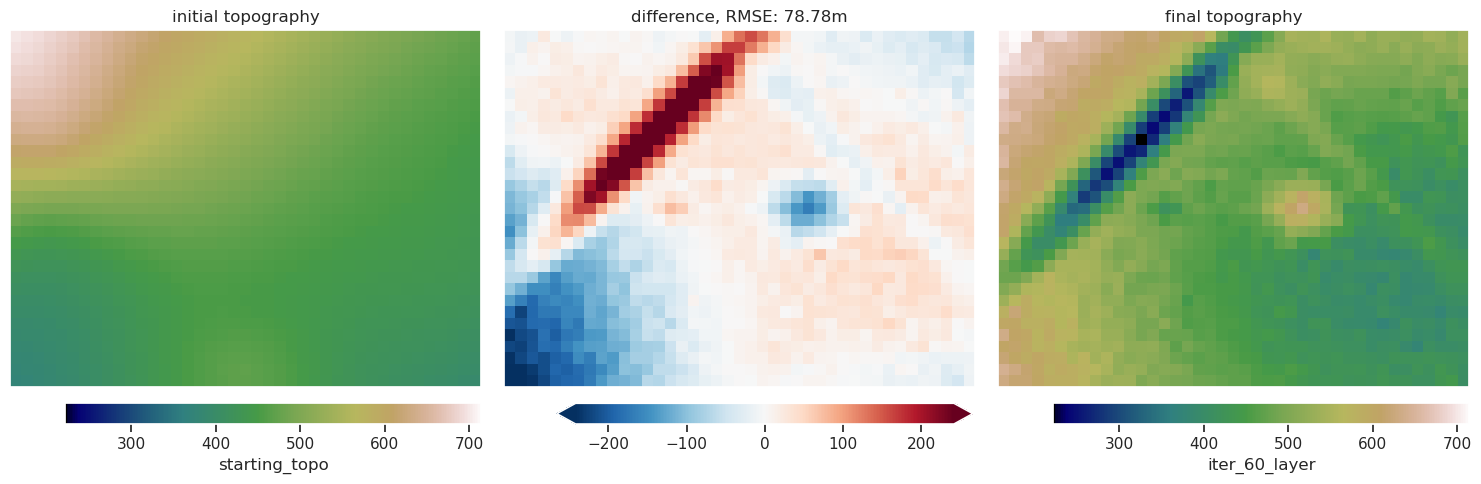

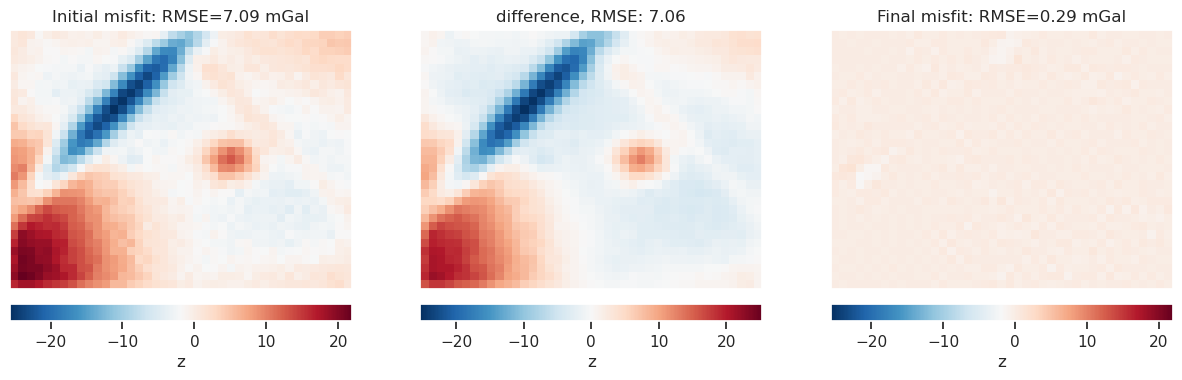

In [11]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    spacing,
    iters_to_plot=4,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

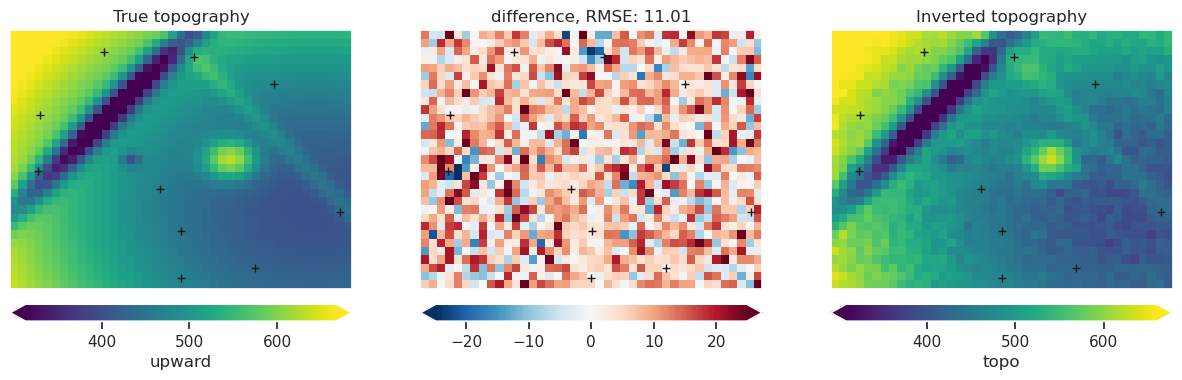

In [12]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    # reverse_cpt=True,
    # cmap="rain",
    diff_lims=(-20, 20),
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
)

As we can see by the low error values surround the constraints (black crosses), include the weighting grid has help the inversion adhere to the constraints. We can sample the inverted topography at the constraints and compare with the constraints true values.

In [13]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 3.14 m


#